In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
import numpy as np
import os
import shutil
import random

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Oversampling

In [3]:
def check_classes_amount(set_with_labels):
    counter = [1,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0]
    count = 0
    for j in range(88010):
        if set_with_labels[j][1] == set_with_labels[j+1][1]:
            counter[count] = counter[count] + 1
        else:
            count += 1
            counter[count] = counter[count] + 1

    return counter

In [4]:
def over_sample_bread_carbon():
    classes_amounts = check_classes_amount(trainset)
    sub_folders = os.listdir("./train")
    list_of_images_bread = os.listdir(f"./train/{sub_folders[10]}")
    list_of_images_carbon = os.listdir(f"./train/{sub_folders[13]}")

    to_oversample_bread = random.sample(list_of_images_bread, k=(1800 - classes_amounts[10]))
    to_oversample_carbon = random.sample(list_of_images_carbon, k= (1800 - 3 * classes_amounts[13]))

    # oversample bread class
    for i in range(len(to_oversample_bread)):
        shutil.copy(f"./train/{sub_folders[10]}/{to_oversample_bread[i]}", f"./train/{sub_folders[10]}/{[name[:-5] + '_1' + name[-5:] for name in to_oversample_bread][i]}")

    # oversample carbon class
    for i in range(classes_amounts[13]):
        shutil.copy(f"./train/{sub_folders[13]}/{list_of_images_carbon[i]}", f"./train/{sub_folders[13]}/{[name[:-5] + '_1' + name[-5:] for name in list_of_images_carbon][i]}")

    for i in range(classes_amounts[13]):
        shutil.copy(f"./train/{sub_folders[13]}/{list_of_images_carbon[i]}", f"./train/{sub_folders[13]}/{[name[:-5] + '_2' + name[-5:] for name in list_of_images_carbon][i]}")

    for i in range(len(to_oversample_carbon)):
        shutil.copy(f"./train/{sub_folders[13]}/{to_oversample_carbon[i]}", f"./train/{sub_folders[13]}/{[name[:-5] + '_3' + name[-5:] for name in to_oversample_carbon][i]}")

In [5]:
trainset = datasets.ImageFolder("train/")
# over_sample_bread_carbon()

# Create val folder

In [6]:
def create_val_folder():
    sub_folders = os.listdir("./train")
    os.mkdir("./val")
    for sub_folder in sub_folders:
        os.mkdir(f"./val/{sub_folder}")

    for sub_folder in sub_folders:
        to_move = random.sample(os.listdir(f"./train/{sub_folder}"), k=360)
        for image in to_move:
            shutil.move(f"./train/{sub_folder}/{image}", f"./val/{sub_folder}/{image}")

create_val_folder()

# Data preparation

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(0.5),
#      transforms.RandomVerticalFlip(0.5),
#      transforms.RandomRotation(24),
#      transforms.ToTensor(),
#      transforms.RandomErasing(0.4),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 64

In [25]:
trainset = datasets.ImageFolder("train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = datasets.ImageFolder("val/", transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.ImageFolder("test_all/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = tuple(trainset.classes)

In [26]:
print(len(trainloader))
print(len(valloader))

1125
282


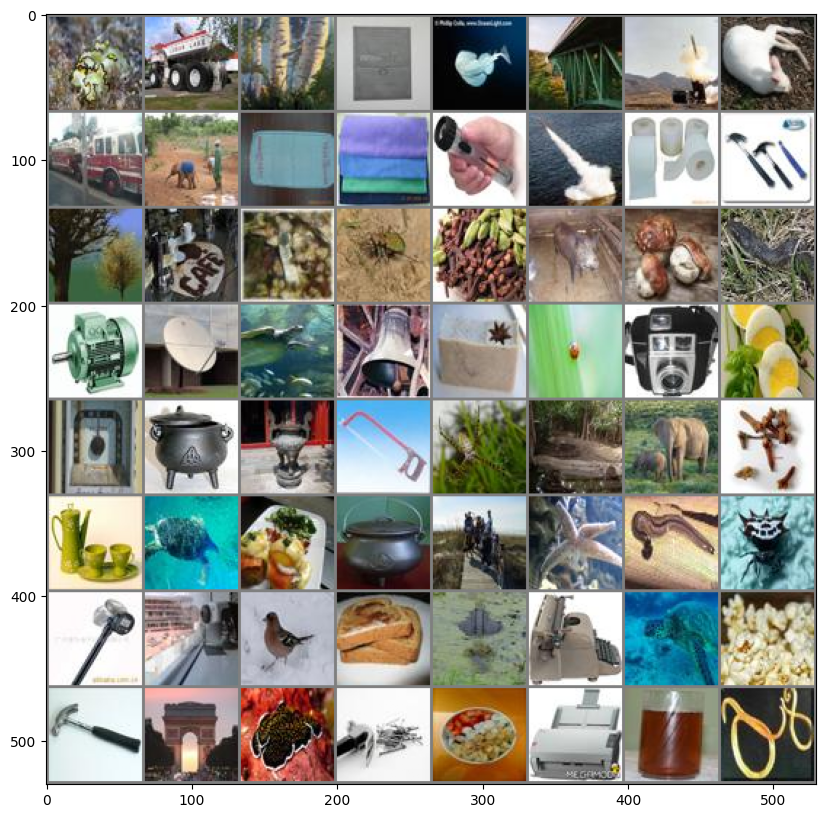

 worm truck birch memorial  fish bridge  bomb kangaroo truck elephant towel towel battery  bomb towel hammer birch   pot  worm beetle spice swine fungus snake motor antenna turtle acoustic spice beetle camera   egg gauge   pot   pot   saw spider swine elephant spice   pot turtle bread   pot bicycle echinoderm  worm spider gauge camera  bird bread crocodilian printer turtle  corn hammer memorial  worm hammer icecream antenna   tea  worm


In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [28]:
images[30:31].size()

torch.Size([1, 3, 64, 64])

In [29]:
def get_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            # calculate outputs by running images through the network
            outputs = net(images).cpu()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    return 100 * correct / total


# Net preparation

In [75]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
##Warstwakonwolucyjna
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
##Warstwamaxpooling
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,100,3)
        self.bn2 = nn.BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(4)
        self.fc0 = nn.Linear(4900,2450)
        self.fc1 = nn.Linear(2450,1225)
        self.fc2 = nn.Linear(1225,600)
        self.fc3 = nn.Linear(600, 200)
        self.fc4 = nn.Linear(200,50)


    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)#flattenalldimensionsexceptbatch
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=4900, out_features=2450, bias=True)
  (fc1): Linear(in_features=2450, out_features=1225, bias=True)
  (fc2): Linear(in_features=1225, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=50, bias=True)
)

In [76]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [77]:
from tqdm import tqdm

epochs = 30
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1, epochs,  running_loss / len(trainloader)))
    running_loss = 0.0


    print(f"accuracy on trainloader: {get_accuracy(trainloader)}")
    print(f"accuracy on valloader: {get_accuracy(valloader)}")
print('Finished Training')

1125it [01:39, 11.33it/s]


[1/30] loss: 3.265
accuracy on trainloader: 20.458333333333332
accuracy on valloader: 19.966666666666665


1125it [01:38, 11.46it/s]


[2/30] loss: 2.761
accuracy on trainloader: 31.31111111111111
accuracy on valloader: 29.455555555555556


1125it [01:36, 11.67it/s]


[3/30] loss: 2.456
accuracy on trainloader: 38.34027777777778
accuracy on valloader: 35.2


1125it [01:36, 11.63it/s]


[4/30] loss: 2.234
accuracy on trainloader: 42.78472222222222
accuracy on valloader: 37.52777777777778


1125it [01:35, 11.73it/s]


[5/30] loss: 2.050
accuracy on trainloader: 48.40694444444444
accuracy on valloader: 40.166666666666664


1125it [01:35, 11.72it/s]


[6/30] loss: 1.872
accuracy on trainloader: 51.40277777777778
accuracy on valloader: 40.51111111111111


1125it [01:35, 11.84it/s]


[7/30] loss: 1.697
accuracy on trainloader: 56.94305555555555
accuracy on valloader: 41.88333333333333


1125it [01:35, 11.73it/s]


[8/30] loss: 1.513
accuracy on trainloader: 63.295833333333334
accuracy on valloader: 42.666666666666664


1125it [01:37, 11.57it/s]


[9/30] loss: 1.326
accuracy on trainloader: 67.86666666666666
accuracy on valloader: 42.0


1125it [01:30, 12.39it/s]


[10/30] loss: 1.146
accuracy on trainloader: 72.8
accuracy on valloader: 42.25555555555555


1125it [01:22, 13.62it/s]


[11/30] loss: 0.970
accuracy on trainloader: 76.625
accuracy on valloader: 41.7


1125it [01:08, 16.36it/s]


[12/30] loss: 0.824
accuracy on trainloader: 81.76388888888889
accuracy on valloader: 42.15


1125it [01:01, 18.34it/s]


[13/30] loss: 0.705
accuracy on trainloader: 83.97361111111111
accuracy on valloader: 41.483333333333334


1125it [01:01, 18.25it/s]


[14/30] loss: 0.607
accuracy on trainloader: 85.50138888888888
accuracy on valloader: 41.227777777777774


1125it [01:00, 18.51it/s]


[15/30] loss: 0.526
accuracy on trainloader: 88.3013888888889
accuracy on valloader: 41.18333333333333


1125it [01:28, 12.65it/s]


[16/30] loss: 0.482
accuracy on trainloader: 89.98472222222222
accuracy on valloader: 40.827777777777776


1030it [01:27, 11.77it/s]


KeyboardInterrupt: 

In [88]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# images = images[10:20]

# print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [89]:
outputs = net(images.to(device))
#outputs
print(len(outputs))

64


In [90]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(predicted))))

Predicted:  hammer motor towel spice tomato   egg antenna   saw spoon pizza   tea   pot echinoderm hammer flower monkey   tea gauge squash  frog spoon  bean camera camera motor beetle  nest  frog  frog hammer icecream squash  frog  fish  fish   cat acoustic printer tomato hammer snake monkey squash pizza  frog   cat monkey kangaroo elephant acoustic  corn  palm squash   tea spice beetle  nest  frog fungus swine camera turtle fungus towel


## Making predictions to .csv

In [96]:
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        for i in predicted:
            predictions.append(classes[i])

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

In [98]:
results = pd.DataFrame(predictions)
results.to_csv('Kusmierz_Podolec.csv', header=None, index=None)

In [110]:
results[0].unique()

array(['hammer', 'motor', 'towel', 'spice', 'tomato', 'egg', 'antenna',
       'saw', 'spoon', 'pizza', 'tea', 'pot', 'echinoderm', 'flower',
       'monkey', 'gauge', 'squash', 'frog', 'bean', 'camera', 'beetle',
       'nest', 'icecream', 'fish', 'cat', 'acoustic', 'printer', 'snake',
       'kangaroo', 'elephant', 'corn', 'palm', 'fungus', 'swine',
       'turtle', 'crab', 'birch', 'spider', 'bicycle', 'truck', 'battery',
       'memorial', 'bread', 'carbon', 'bridge', 'bomb', 'bird', 'worm',
       'crocodilian', 'bacteria'], dtype=object)